In [1]:
# Tensorflow and numpy to create the neural network
import tensorflow as tf
import numpy as np

# Matplotlib to plot info to show our results
import matplotlib.pyplot as plt

# OS to load files and save checkpoints
import os

%matplotlib inline

Image Recognition
===

This notebook will create a convolutional neural network to classify images in either the mnist or cifar-10 datasets.

Loading the data
---

This code will load the dataset that you'll use to train and test the model.

The code provided will load the mnist or cifar data from files, you'll need to add the code that processes it into a format your neural network can use.

MNIST
---

Run this cell to load mnist data.

In [2]:
# Load MNIST data from tf examples

image_height = 28
image_width = 28

color_channels = 1

model_name = "mnist"

mnist = tf.contrib.learn.datasets.load_dataset("mnist")

train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

category_names = list(map(str, range(10)))

# TODO: Process mnist data
print(train_data.shape)

train_data = np.reshape(train_data, (-1, image_height, image_width, color_channels))

print(train_data.shape)

eval_data = np.reshape(eval_data, (-1, image_height, image_width, color_channels))

W0626 10:37:07.210175 140516154582848 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0626 10:37:07.210913 140516154582848 deprecation.py:323] From <ipython-input-2-8cf8bab2c74e>:10: load_dataset (from tensorflow.contrib.learn.python.learn.datasets) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data.
W0626 10:37:07.211374 140516154582848 deprecation.py:323] From /home/idstudent/.local/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/__init__.py:80: load_mnist (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruct

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz


W0626 10:37:07.415380 140516154582848 deprecation.py:323] From /home/idstudent/.local/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 28, 28, 1)


CIFAR-10
---

Run this cell to load cifar-10 data

In [ ]:
# Load cifar data from file

image_height = 32
image_width = 32

color_channels = 3

model_name = "cifar"

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_path = './cifar-10-data/cifar-10-batches-py/'

train_data = np.array([])
train_labels = np.array([])

# Load all the data batches.
for i in range(1, 2):
    data_batch = unpickle(cifar_path + 'data_batch_' + str(i))
    train_data = np.append(train_data, data_batch[b'data'])
    train_labels = np.append(train_labels, data_batch[b'labels'])

# Load the eval batch.
eval_batch = unpickle(cifar_path + 'test_batch')

eval_data = eval_batch[b'data']
eval_labels = eval_batch[b'labels'] 

# Load the english category names.
category_names_bytes = unpickle(cifar_path + 'batches.meta')[b'label_names']
category_names = list(map(lambda x: x.decode("utf-8"), category_names_bytes))

# TODO: Process Cifar data

def process_data(data):
    float_data = np.array(data, dtype=float) / 255.0
    
    reshaped_data = np.reshape(float_data, (-1, color_channels, image_height, image_width))
    
    transposed_data = np.transpose(reshaped_data, [0, 2, 3, 1])
    
    return transposed_data

train_data = process_data(train_data)

eval_data = process_data(eval_data)

Once the data is processed, you have a few variables for the data itself and info about its shape:

### Model Info

- **image_height, image_width** - The height and width of the processed images
- **color_channels** - the number of color channels in the image. This will be either 1 for grayscale or 3 for rgb.
- **model_name** - either "cifar" or "mnist" - if you need to handle anything differently based on the model, check this variable.
- **category_names** - strings for each category name (used to print out labels when testing results)

### Training Data

- **train_data** - the training data images
- **train_labels** - the labels for the training data - the "answer key"

### Evaluation Data

- **eval_data** - Image data for evaluation. A different set of images to test your network's effectiveness.
- **eval_labels** - the answer key for evaluation data.

Building the Neural Network Model
--

Next, you'll build a neural network with the following architecture:

- An input placeholder that takes one or more images.
- 1st Convolutional layer with 32 filters and a kernel size of 5x5 and same padding
- 1st Pooling layer with a 2x2 pool size and stride of 2
- 2nd Convolutional layer with 64 filters and a kernel size of 5x5 and same padding
- 2nd Pooling layer with a 2x2 pool size and stride of 2
- Flatten the pooling layer
- A fully connected layer with 1024 units
- A dropout layer with a rate of 0.4
- An output layer with an output size equal to the number of labels.

In [3]:
# TODO: The neural network
class ConvNet:
    
    def __init__(self, image_height, image_width, channels, num_classes):
        
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, channels], name="inputs")
        print(self.input_layer.shape)
        
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        print(conv_layer_1.shape)
        
        #(?, 32, 32, 3)
        #(?, 32, 32, 32)
        
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2,2], strides=2)
        print(pooling_layer_1.shape)
        
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        print(conv_layer_2.shape)
        
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        print(pooling_layer_2.shape)
        
        #(?, 16, 16, 32)
        #(?, 16, 16, 64)
        #(?, 8, 8, 64)
        
        flattened_pooling = tf.layers.flatten(pooling_layer_2)
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training=True)
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
        
        #(?, 1024)
        #(?, 10)
        
        self.choice = tf.argmax(outputs, axis=1)
        self.probability = tf.nn.softmax(outputs)
        
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
        
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)     
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())

The Training Process
---

The cells below will set up and run the training process.

- Set up initial values for batch size, training length.
- Process data into batched datasets to feed into the network.
- Run through batches of training data, update weights, save checkpoints.

In [4]:
# TODO: initialize variables
training_steps = 20000
batch_size = 64

path = "./" + model_name + "-cnn/"

load_checkpoint = False
performance_graph = np.array([])

# TODO: implement the training loop
tf.reset_default_graph()

dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.shuffle(buffer_size=train_labels.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()

cnn = ConvNet(image_height,image_width,color_channels,10)

saver = tf.train.Saver(max_to_keep=2)

if not os.path.exists(path):
    os.makedirs(path)
    
with tf.Session() as sess:
    
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    for step in range(training_steps):
        current_batch = sess.run(next_element)
        
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
        
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
        
        if step % 10 == 0:
            performance_graph = np.append(performance_graph, sess.run(cnn.accuracy))
        
        if step % 1000 == 0 and step > 0:
            current_acc = sess.run(cnn.accuracy)
            
            print("Accuracy at step " + str(step) + ": " + str(current_acc))
            print("Saving checkpoint")
            saver.save(sess, path + model_name, step)
        
    print("Saving final checkpoint for training session.")
    saver.save(sess, path + model_name, step)

W0626 10:37:22.361980 140516154582848 deprecation.py:323] From <ipython-input-4-75274a3d4273>:18: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0626 10:37:22.367172 140516154582848 deprecation.py:323] From <ipython-input-3-3e26aef35837>:9: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0626 10:37:22.368829 140516154582848 deprecation.py:506] From /home/idstudent/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype i

(?, 28, 28, 1)
(?, 28, 28, 32)
(?, 14, 14, 32)


W0626 10:37:22.570985 140516154582848 deprecation.py:323] From <ipython-input-3-3e26aef35837>:28: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0626 10:37:22.692490 140516154582848 deprecation.py:323] From <ipython-input-3-3e26aef35837>:29: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


(?, 14, 14, 64)
(?, 7, 7, 64)


W0626 10:37:22.848939 140516154582848 deprecation.py:323] From <ipython-input-3-3e26aef35837>:31: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
W0626 10:37:22.933776 140516154582848 deprecation.py:323] From /home/idstudent/.local/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(?, 1024)
(?, 10)
Accuracy at step 1000: 0.82551855
Saving checkpoint
Accuracy at step 2000: 0.88686866
Saving checkpoint


W0626 10:39:07.759806 140516154582848 deprecation.py:323] From /home/idstudent/.local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Accuracy at step 3000: 0.91218275
Saving checkpoint
Accuracy at step 4000: 0.9267655
Saving checkpoint
Accuracy at step 5000: 0.93635106
Saving checkpoint
Accuracy at step 6000: 0.94320315
Saving checkpoint
Accuracy at step 7000: 0.94838566
Saving checkpoint
Accuracy at step 8000: 0.9525995
Saving checkpoint
Accuracy at step 9000: 0.95602125
Saving checkpoint
Accuracy at step 10000: 0.9588711
Saving checkpoint
Accuracy at step 11000: 0.9612825
Saving checkpoint
Accuracy at step 12000: 0.9633676
Saving checkpoint
Accuracy at step 13000: 0.9652192
Saving checkpoint
Accuracy at step 14000: 0.9668515
Saving checkpoint
Accuracy at step 15000: 0.9683745
Saving checkpoint
Accuracy at step 16000: 0.9697042
Saving checkpoint
Accuracy at step 17000: 0.970883
Saving checkpoint
Accuracy at step 18000: 0.9719882
Saving checkpoint
Accuracy at step 19000: 0.9729967
Saving checkpoint
Saving final checkpoint for training session.


Evaluating Performance
---

These cells will evaluate the performance of your network!

Text(0, 0.5, 'Accuracy')

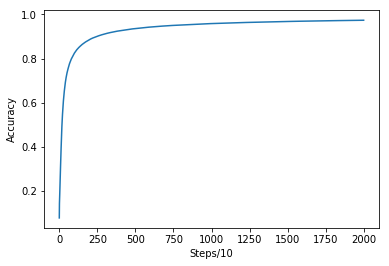

In [8]:
plt.plot(performance_graph)
plt.xlabel("Steps/10")
plt.ylabel("Accuracy")

In [9]:
# Run through the evaluation data set, check accuracy of model
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
    
    sess.run(tf.local_variables_initializer())
    
    for image, label in zip(eval_data, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})
    
    print(sess.run(cnn.accuracy))

0.9883


0.9877


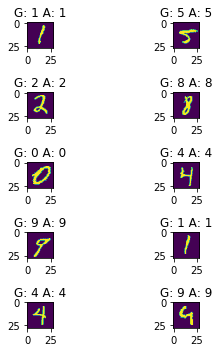

In [10]:
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
    
    sess.run(tf.local_variables_initializer())
    
    for image, label in zip(eval_data, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})
    
    print(sess.run(cnn.accuracy))# TODO: Get a random set of images and make guesses for each
    
    indexes = np.random.choice(len(eval_data), 10, replace=False)

# Loads images from indices, display the network's guess and label.

    rows = 5
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(5,5))
    fig.patch.set_facecolor('white')
    image_count = 0

    for idx in indexes:
        image_count += 1
        sub = plt.subplot(rows,cols,image_count)
        img = eval_data[idx]

        if model_name == "mnist":
            img = img.reshape(28, 28)
        plt.imshow(img)
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[eval_data[idx]]})

        if model_name == "mnist":
            guess_name = str(guess[0])
            actual_name = str(eval_labels[idx])
        else:
            guess_name = category_names[guess[0]]
            actual_name = category_names[eval_labels[idx]]
        sub.set_title("G: " + guess_name + " A: " + actual_name)
        
    plt.tight_layout()